# Imports

In [2]:
import sys
sys.path.insert(1, "..")
from collections import namedtuple
import dill
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import get_full_kernels_in_kernel_expression
from globalParams import options, hyperparameter_limits
import gpytorch
from itertools import chain
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from metrics import calculate_AIC as AIC, calculate_BIC as BIC, calculate_laplace as Laplace, NestedSampling as Nested, log_normalized_prior
import numpy as np
import os
import pandas
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch
from scipy.stats import multivariate_normal, spearmanr
import torch

# Data generation

## 2D

In [ ]:


def periodic_1D(X):
    return torch.sin(X[0])

def periodic_2D(X):
    return torch.sin(X[0]) * torch.sin(X[1])

def parabola_1D(X):
    return X[0]**2

def product(X):
    return X[0] * X[1]

def periodic_sum(X):
    return torch.sin(X[0] + X[1])

def periodic_sincos(X):
    return torch.sin(X[0]) * torch.cos(X[1])




# Helper functions

In [6]:
hyperparameter_limits = {"RBFKernel": {"lengthscale": [1e-3,1]},
                         "MaternKernel": {"lengthscale": [1e-3,1]},
                         "LinearKernel": {"variance": [1e-4,1]},
                         "AffineKernel": {"variance": [1e-4,1]},
                         "RQKernel": {"lengthscale": [1e-3,1],
                                      "alpha": [1e-3,1]},
                         "CosineKernel": {"period_length": [1e-3,3]},
                         "PeriodicKernel": {"lengthscale": [1e-3,1],
                                            "period_length": [1e-3,3]},
                         "ScaleKernel": {"outputscale": [1e-3,10]},
                         "Noise": [1e-2,1e-1],
                         "MyPeriodKernel":{"period_length": [1e-3,3]}}

def random_reinit(model):
    #print("Random reparameterization")
    #print("old parameters: ", list(model.named_parameters()))
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value
    #print("new parameters: ", list(model.named_parameters()))


def fixed_reinit(model, parameters):
    for i, (param, value) in enumerate(zip(model.parameters(), parameters)):
        param.data = torch.full_like(param.data, value)



# Define the training loop
def optimize_hyperparameters(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """

    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    uninformed = kwargs.get("uninformed", False)
    random_restarts = int(2)
    train_log = [list() for _ in range(random_restarts)]

    """
    # The call that comes from GRANSO
    user_halt = halt_log_fn(0, x, self.penaltyfn_at_x, np.zeros((n,1)),
                                        get_bfgs_state_fn, H_QP,
                                        1, 0, 1, stat_vec, self.stat_val, 0          )
    """
    def log_fnct(*args):
        train_log[restart].append((args[1], args[2].f))
        return False 

    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    MAP = kwargs.get("MAP", True)
    double_precision = kwargs.get("double_precision", False)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    opts.globalAD = True
    opts.double_precision = double_precision
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False
    opts.halt_log_fn = log_fnct

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        try:
            # TODO PyGRANSO dying is a severe problem. as it literally exits the program instead of raising an error
            #import pdb;pdb.set_trace()
            loss = -mll(output, train_y)
        except Exception as E:
            print("LOG ERROR: Severe PyGRANSO issue. Loss is inf+0")
            loss = torch.tensor(np.inf, requires_grad=True) + torch.tensor(0)
        if MAP:
            # log_normalized_prior is in metrics.py 
            log_p = log_normalized_prior(model, uninformed=uninformed)
            loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    best_f = np.inf
    for restart in range(random_restarts):
        # Train the model using PyGRANSO
        try:
            soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
            print(f"Restart {restart} : trained parameters: {list(model.named_parameters())}")
        except Exception as e:
            print(e)
            import pdb
            pdb.set_trace()
            pass

        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        random_reinit(model)
        opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)
    print(f"----")
    print(f"Final best parameters: {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
    print(f"----")

    loss = -mll(model(train_x), train_y)
    if MAP:
        log_p = log_normalized_prior(model)
        loss -= log_p

    #print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    #print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    #print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood, train_log


def get_std_points(mu, K):
    x, y = np.mgrid[-3:3:.1, -3:3:.1]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = 50
    unit_x = torch.cat([torch.linspace(-1, 1, precision), torch.linspace(-1, 1, precision)])
    unit_y = torch.cat([torch.sqrt(1 - torch.linspace(-1, 1, precision)**2), -torch.sqrt(1 - torch.linspace(-1, 1, precision)**2)])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + 2*res[0])
        new_unit_y.append(mu[1] + 2*res[1])
    return new_unit_x, new_unit_y


# Find all points inside the confidence ellipse
def percentage_inside_ellipse(mu, K, points, sigma_level=2):
    L = np.linalg.cholesky(K)
    threshold = sigma_level ** 2
    count = 0
    for point in points:
        res = np.array(point - mu) @ np.linalg.inv(L)
        if res @ res <= threshold:
            count += 1
    return count / len(points)


def log_dill(data, filename):
    with open(filename, 'wb') as f:
        dill.dump(data, f)

# Plotting functions

## Training

In [7]:
def plot_parameter_progression(parameter_progression, losses=None, xlabel=None, ylabel=None, fig=None, ax=None, xdim=0, ydim=1, display_figure=True, return_figure=False, title_add=""):
    if not (fig and ax):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    for i in range(1, len(parameter_progression)):


        if losses is None:
            colormap = plt.cm.viridis(i/len(parameter_progression))
        else:
            colormap = plt.cm.viridis(losses[i]/min(losses))
        ax.plot([parameter_progression[i-1][xdim], parameter_progression[i][xdim]], [parameter_progression[i-1][ydim], parameter_progression[i][ydim]], color=colormap)

        ax.annotate("",
                xy=(parameter_progression[i][xdim], parameter_progression[i][ydim]), xytext=(parameter_progression[i-1][xdim], parameter_progression[i-1][ydim]),  # Arrow from second-last to last point
                arrowprops=dict(arrowstyle="->", color=colormap, lw=2))
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.set_title(f"Parameter progression {title_add}")
    fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax)
    #plt.colorbar(likelihood_surface_scatter)

    if return_figure:
        return fig, ax
    if display_figure:
        plt.show()
    return None, None


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_parameter_progression(parameter_progression, losses=None, xlabel=None, ylabel=None, fig=None, ax=None, xdim=0, ydim=1, display_figure=True, return_figure=False, title_add=""):
    if not (fig and ax):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Reverse colormap by using "viridis_r"
    cmap = plt.cm.viridis_r  

    # Define a normalization based on loss values
    norm = None
    if losses is not None:
        norm = mcolors.Normalize(vmin=min(losses[1:]), vmax=max(losses[1:]))  # Keep vmin and vmax as usual
    
    for i in range(1, len(parameter_progression)):
        if losses is None:
            colormap = cmap(i / len(parameter_progression))  # Use reversed colormap
        else:
            colormap = cmap(norm(losses[i]))  # Normalize and apply reversed colormap
        
        ax.plot([parameter_progression[i-1][xdim], parameter_progression[i][xdim]], 
                [parameter_progression[i-1][ydim], parameter_progression[i][ydim]], 
                color=colormap)

        ax.annotate("", xy=(parameter_progression[i][xdim], parameter_progression[i][ydim]), 
                    xytext=(parameter_progression[i-1][xdim], parameter_progression[i-1][ydim]),  
                    arrowprops=dict(arrowstyle="->", color=colormap, lw=2))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Parameter progression {title_add}")

    # Add colorbar with reversed colormap
    if losses is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Use reversed colormap here
        sm.set_array([])  # Required for colorbar
        fig.colorbar(sm, ax=ax, label="Loss value (higher = worse)")

    if return_figure:
        return fig, ax
    if display_figure:
        plt.show()
    return None, None


## Nested

In [9]:

# Stolen from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(mu, K, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    cov = K
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0] 

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def nested_sampling_plot(model, model_evidence_log, xdim=0, ydim=1, filter_type="none", std_filter=1e-0, return_figure=False, title_add="", fig=None, ax=None, display_figure=True, plot_mll_opt=False, mll_opt_params=None, plot_lap=False, Lap0_logs=None, LapAIC_logs=None, LapBIC_logs=None, lap_colors = ["r", "pink", "black"]):

    if not (fig and ax):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    with open(f"{model_evidence_log['res file']}", "rb") as f:
        res = dill.load(f)
    
    # Plot the actual figure
    param_names = [l[0] for l in list(model.named_parameters())]

    # Find the best value and the corresponding hyperparameters
    best_idx = np.argmax(res.logl)
    best_hyperparameters = res.samples[best_idx]

    # Do an outlier cleanup on res.logz
    logz_std = np.std(res.logz)
    if filter_type == "max":
        mask = res.logz >= max(res.logz)+std_filter*logz_std
    elif filter_type == "mean":
        raise NotImplementedError("This filter type is not implemented yet")
        logz_mean = np.mean(res.logz)
        mask = np.all(logz_mean - abs(std_filter) * logz_std <= res.logz <= logz_mean + abs(std_filter) * logz_std)
    elif filter_type == "none":
        mask = res.logz == res.logz



    likelihood_surface_scatter = ax.scatter(res.samples[:,xdim][mask], res.samples[:,ydim][mask], c=res.logz[mask], s=3)
    # Best found hyperparameters
    ax.scatter(best_hyperparameters[xdim], best_hyperparameters[ydim], c="r", s=10)

    if plot_mll_opt and not mll_opt_params is None:
        ax.scatter(mll_opt_params[xdim], mll_opt_params[ydim], c="black", s=10)
        # Add a small text beside the point saying "MLL"
        ax.text(mll_opt_params[xdim], mll_opt_params[ydim], "MLL", fontsize=12, color="black", verticalalignment='center', horizontalalignment='right')
    
    coverages = list()
    if plot_lap:
        # Plot the Laplace levels
        for lap_log, lap_color in zip([Lap0_logs, LapAIC_logs, LapBIC_logs], lap_colors):
            if lap_log is None:
                continue
            lap_param_mu = lap_log["parameter values"]
            # Wait a minute, isn't the Hessian the inverse of the covariance matrix? Yes, see Murphy PML 1 eq. (7.228)
            lap_param_cov_matr = torch.linalg.inv(lap_log["corrected Hessian"])
            # Calculate the amount of samples that are covered by the 1 sigma and 2 sigma interval based on the lap_mu and lap_cov values
            lap_2_sig_coverage = percentage_inside_ellipse(lap_param_mu.flatten().numpy(), lap_param_cov_matr.numpy(), res.samples[mask])
            coverages.append(lap_2_sig_coverage)
            #ax.scatter(lap_param_mu[xdim], lap_param_mu[ydim], c="b", s=10)

            # Plot the std points
            lap_mu_filtered = lap_param_mu.numpy()[[xdim, ydim]] 
            lap_cov_filtered = lap_param_cov_matr.numpy()[[xdim, ydim]][:,[xdim, ydim]]
            #lap_var_ellipse_x, lap_var_ellipse_y = get_std_points(lap_mu_filtered.flatten(), lap_cov_filtered)
            #plt.scatter(lap_var_ellipse_x, lap_var_ellipse_y, c="b", s=1)
            confidence_ellipse(lap_mu_filtered, lap_cov_filtered, ax, n_std=2, edgecolor=lap_color, lw=1)

    ax.set_title(f"#Samples: {sum(res.ncall)}; {coverages[0]*100:.0f}% inside 2 sigma")
    ax.set_xlabel(param_names[xdim])

    plt.colorbar(likelihood_surface_scatter)

    if return_figure:
        return fig, ax
    if display_figure:
        plt.show()
    return None, None

## 1D

In [10]:

def plot_data(X, Y, return_figure=False, title_add="", figure=None, ax=None, display_figure=True):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.plot(X.numpy(), Y.numpy(), 'k.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f"Data {title_add}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax

def plot_model(model, likelihood, X, Y, display_figure=True, return_figure=False, figure=None,
               ax=None, loss_val=None, loss_type = None):
    interval_length = torch.max(X) - torch.min(X)
    shift = interval_length * options["plotting"]["border_ratio"]
    test_x = torch.linspace(torch.min(
        X) - shift, torch.max(X) + shift, options["plotting"]["sample_points"])

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        if not (figure and ax):
            figure, ax = plt.subplots(1, 1, figsize=(8, 6))

        lower, upper = observed_pred.confidence_region()
        ax.plot(X.numpy(), Y.numpy(), 'k.', zorder=2)
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), color="b", zorder=3)
        amount_of_gradient_steps = 30
        alpha_min = 0.05
        alpha_max = 0.8
        alpha = (alpha_max-alpha_min)/amount_of_gradient_steps
        c = ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(
        ), alpha=alpha+alpha_min, zorder=1).get_facecolor()

        for i in range(1, amount_of_gradient_steps):
            ax.fill_between(test_x.numpy(), (lower+(i/amount_of_gradient_steps)*(upper-lower)).numpy(),
                            (upper-(i/amount_of_gradient_steps)*(upper-lower)).numpy(), alpha=alpha, color=c, zorder=1)
        if options["plotting"]["legend"]:
            ax.plot([], [], 'k.', label="Data")
            ax.plot([], [], 'b', label="Mean")
            ax.plot([], [], color=c, alpha=1.0, label="Confidence")
            ax.legend(loc="upper left")
        ax.set_xlabel("Normalized Input")
        ax.set_ylabel("Normalized Output")
        ax.set_title(f"{loss_type}: {loss_val:.2f}")
    if not return_figure and display_figure:
        plt.show()
    else:
        return figure, ax



## 2D

In [49]:
def plot_3d_data(samples, xx, yy, return_figure=False, fig=None, ax=None, display_figure=True, title_add = ""):
    """
    Similar to plot_3d_gp_samples, but color-codes each (xx, yy) point in 3D.
    'samples' can be a single 1D tensor or multiple samples in a 2D tensor.
    """
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

    if samples.ndim == 1:
        samples = samples.unsqueeze(0)

    for sample in samples:
        z_vals = sample.reshape(xx.shape)
        ax.scatter(xx.numpy(), yy.numpy(), z_vals.numpy(),
                   c=z_vals.numpy(), cmap='viridis', alpha=0.8)


    # Plot shadows (projection on X-Y plane at z=0)
    ax.scatter(xx.numpy(), yy.numpy(), np.ones_like(z_vals)*min(z_vals.numpy()), c='gray', alpha=0.3, marker='o')



    ax.set_title(f'Data {title_add}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output Value')
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax


def plot_3d_gp_samples(samples, xx, yy, return_figure=False, fig=None, ax=None, display_figure=True):
    """
    Visualize multiple samples drawn from a 2D-input (xx, yy) -> 1D-output GP in 3D.
    Each sample in 'samples' should be a 1D tensor that can be reshaped to match xx, yy.
    """
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if samples.ndim == 1:
        samples = samples.unsqueeze(0)
    for i, sample in enumerate(samples):
        z_vals = sample.reshape(xx.shape)
        ax.plot_surface(xx.numpy(), yy.numpy(), z_vals.numpy(), alpha=0.4)

    ax.set_title('GP Samples in 3D')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')
    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax


def plot_3d_gp(model, likelihood, data=None, x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,
                resolution=50, return_figure=False, fig=None, ax=None, display_figure=True):
    if not (fig and ax):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')


    if data is not None:
        if data.ndim == 1:
            data = data.unsqueeze(0)

        for sample in data:
            xx = sample[0]
            yy = sample[1]
            zz = sample[2]
            ax.scatter(xx.numpy(), yy.numpy(), zz.numpy(), color="red", alpha=0.8)


    model.eval()
    likelihood.eval()

    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    xx, yy = torch.meshgrid(x_vals, y_vals)
    test_x = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds = likelihood(model(test_x))
        mean = preds.mean.reshape(resolution, resolution)
        lower, upper = preds.confidence_region()
        lower = lower.reshape(resolution, resolution)
        upper = upper.reshape(resolution, resolution)


    # Plot mean surface
    ax.plot_surface(xx.numpy(), yy.numpy(), mean.numpy(), cmap='viridis', alpha=0.8)

    # Plot lower and upper surfaces
    ax.plot_surface(xx.numpy(), yy.numpy(), lower.numpy(), color='gray', alpha=0.2)
    ax.plot_surface(xx.numpy(), yy.numpy(), upper.numpy(), color='gray', alpha=0.2)

    ax.set_title('2D GP in 3D')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Mean and Variance Range')

    if not return_figure and display_figure:
        plt.show()
    else:
        return fig, ax


# Definitions

In [18]:
DatasetInfo = namedtuple('DatasetInfo', ['name', 'path', 'dimension', 'description'])
datasets_1d = {
    "alternating" : DatasetInfo('alternating', 'datasets/alternating.csv', 1, 'Alternates between high and low'),
    "broaden" : DatasetInfo('broaden', 'datasets/broaden.csv', 1, 'Data with increasing variance'),
    "large gap" : DatasetInfo('large gap', 'datasets/large_gap.csv', 1, 'Contains large gap between X values'),
    "linear outlier" : DatasetInfo('linear outlier', 'datasets/linear_outlier.csv', 1, 'Linear data with outlier in last entry'),
    "parabola" : DatasetInfo('parabola', 'datasets/parabola.csv', 1, 'Parabola'),
    "periodic linear" : DatasetInfo('periodic linear', 'datasets/periodic_linear.csv', 1, 'Periodic data that changes to becoming purely linear'),
    "periodic" : DatasetInfo('periodic', 'datasets/periodic.csv', 1, 'Periodic data'),
    "v_lines" : DatasetInfo('v_lines', 'datasets/v_lines.csv', 1, 'Vertical lines'),
}



# named tuple or dictionary for the datasets, same as 1D case
DatasetInfo = namedtuple('DatasetInfo', ['name', 'path', 'dimension', 'description'])
datasets_2d = {
    "away": DatasetInfo('away', 'datasets/2D/away.csv', 2, 'Away from the center'),
    "bullseye": DatasetInfo('bullseye', 'datasets/2D/bullseye.csv', 2, 'Two circles forming a bullseye'),
    "circle": DatasetInfo('circle', 'datasets/2D/circle.csv', 2, 'Circle'),
    "dots": DatasetInfo('dots', 'datasets/2D/dots.csv', 2, 'An equidistant dot grid'),
    "h_lines": DatasetInfo('h_lines', 'datasets/2D/h_lines.csv', 2, 'Horizontal lines'),
    "high lines": DatasetInfo('high lines', 'datasets/2D/high_lines.csv', 2, 'Horizontal lines with a large gap between them'),
    "slant down": DatasetInfo('slant down', 'datasets/2D/slant_down.csv', 2, 'Straight lines slanting downwards'),
    "slant up": DatasetInfo('slant up', 'datasets/2D/slant_up.csv', 2, 'Straight lines slanting upwards'),
    "star": DatasetInfo('star', 'datasets/2D/star.csv', 2, 'Star shape'),
    "v_lines": DatasetInfo('v_lines', 'datasets/2D/v_lines.csv', 2, 'Vertical lines'),
    "wide lines": DatasetInfo('wide lines', 'datasets/2D/wide_lines.csv', 2, 'Vertical lines with a large gap between them'),
    "x_shape": DatasetInfo('x_shape', 'datasets/2D/x_shape.csv', 2, 'X shape'),
}

## GP definition

In [14]:


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()

        if kernel_text == "C*C*SE":
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))
        elif kernel_text == "SE":
            self.covar_module = gpytorch.kernels.RBFKernel()
        elif kernel_text == "C*SE":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel_text == "LIN":
            self.covar_module = gpytorch.kernels.LinearKernel()
        elif kernel_text == "C*LIN":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        elif kernel_text == "LIN*SE":
            self.covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.RBFKernel()
        elif kernel_text == "LIN*PER":
            self.covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "SE+SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "RQ":
            self.covar_module = gpytorch.kernels.RQKernel()
        elif kernel_text == "PER":
            self.covar_module = gpytorch.kernels.PeriodicKernel()
        #elif kernel_text == "PER+SE":
        #    if weights is None:
        #        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #    else:
        #        self.covar_module = weights[0]*gpytorch.kernels.PeriodicKernel() + weights[1]*gpytorch.kernels.RBFKernel()
        elif kernel_text == "PER*SE":
            self.covar_module = gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
        #elif kernel_text == "PER*LIN":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        elif kernel_text == "MAT32":
            self.covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
        elif kernel_text == "MAT32+MAT52":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.MaternKernel()
        elif kernel_text == "MAT32*PER":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT32+PER":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT32*SE":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) * gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT32+SE":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT52":
            self.covar_module = gpytorch.kernels.MaternKernel()
        elif kernel_text == "MAT52*PER":
            self.covar_module =  gpytorch.kernels.MaternKernel() * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "MAT52+SE":
            self.covar_module =  gpytorch.kernels.MaternKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "SE*SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() * gpytorch.kernels.RBFKernel()
        elif kernel_text == "(SE+RQ)*PER":
            self.covar_module =  (gpytorch.kernels.RBFKernel() + gpytorch.kernels.RQKernel()) * gpytorch.kernels.PeriodicKernel()
        elif kernel_text == "SE+SE+SE":
            self.covar_module =  gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif kernel_text == "MAT32+(MAT52*PER)":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=1.5) + (gpytorch.kernels.MaternKernel() * gpytorch.kernels.PeriodicKernel())

        #elif kernel_text == "RQ*PER":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #elif kernel_text == "RQ*MAT32":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        #elif kernel_text == "RQ*SE":
        #    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) * gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class ExactMIGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_text="RBF", weights=None):
        super(ExactMIGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        if kernel_text == "[RBF; RBF]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.RBFKernel(active_dims=1), num_dims=2)
        elif kernel_text == "[RBF; LIN]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.RBFKernel(active_dims=0) + gpytorch.kernels.LinearKernel(active_dims=1), num_dims=2)
        elif kernel_text == "[LIN; RBF]":
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(gpytorch.kernels.LinearKernel(active_dims=0) + gpytorch.kernels.RBFKernel(active_dims=1), num_dims=2)


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Various 1D and 2D datasets 

In [ ]:
possible_kenels = [
    "SE",
    "C*SE",
    "C*C*SE",
    "LIN",
    "C*LIN",
    "LIN*SE",
    "LIN*PER",
    "SE+SE",
    "RQ",
    "PER",
    "PER*SE",
    "MAT32",
    "MAT32+MAT52",
    "MAT32*PER",
    "MAT32+PER",
    "MAT32*SE",
    "MAT32+SE",
    "MAT52",
    "MAT52*PER",
    "MAT52+SE",
    "SE*SE",
    "(SE+RQ)*PER",
    "SE+SE+SE",
    "MAT32+(MAT52*PER)"]

possible_datasets = [
   "alternating",
   "broaden",
   "large gap",
   "linear outlier",
   "parabola",
   "periodic linear",
   "periodic",
   "v_lines"
]

kernel_name = "C*C*SE"
dataset_name = "alternating"
dataset_addendum = ""#"51 points"
data_normalization = True
data_norm_y = False 
levels = [1e+4, 1e+5]
uninformed = True

log_path = f"logs/{'x-normalized' if data_normalization else ''}_{dataset_name}_{dataset_addendum}/{kernel_name}"
if not os.path.exists(log_path):
    os.makedirs(log_path)

## 1D data

In [ ]:


# Load the dataset
if dataset_name in datasets_1d:
    df = pandas.read_csv(datasets_1d[dataset_name].path, header=None)
    train_x = torch.tensor(df[0], dtype=torch.float32)
    train_y = torch.tensor(df[1], dtype=torch.float32)

elif dataset_name == "linear":
    train_x = torch.linspace(0, int(dataset_addendum.split(" ")[0])-1, int(dataset_addendum.split(" ")[0]))
    train_y = train_x.clone()
    #train_y[-1] = 0 


# Z score normalization
if data_normalization:
    train_x = (train_x - train_x.mean()) / train_x.std()
    if data_norm_y:
        train_y = (train_y - train_y.mean()) / train_y.std()

fig, ax = plot_data(train_x, train_y, title_add=dataset_name, return_figure=True)
fig.savefig(f"{log_path}/data.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/data.pgf", bbox_inches='tight')

In [ ]:
len(train_x)

In [ ]:
## Define the GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
model_MAP = ExactGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)

In [ ]:
model

In [ ]:
param_names = [l[0] for l in list(model.named_parameters())]

In [ ]:
## Train the GPs
model.train()
likelihood.train()
mll_loss, model, likelihood, mll_train_log = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False, uninformed=uninformed)
mll_opt_params = [p.item() for p in model.parameters() if p.requires_grad]

In [ ]:
# Plot the optimization path of the trainings, each in an individual plot, given the parameter of interest
# The parameter progression is plotted as arrows pointing to the next parameter position
# The arrows are colored according to the lateness of their progression
# The colorbar shows the progression of the parameter


random_restarts = 2

f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]

xdim = 0
ydim = 1
# extract all the parameters

parameter_paths = [[log[0] for log in mll_train_log[i]] for i in range(len(mll_train_log))]
parameter_values = [[log[1] for log in mll_train_log[i]] for i in range(len(mll_train_log))]

for i, ax in enumerate(axs):
    # train log consists of a list of tuples, where the first element is the parameter vector and the second element is the loss
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model_MAP.train()
likelihood_MAP.train()
map_loss, model_MAP, likelihood_MAP, map_train_log = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True, uninformed=uninformed)
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

In [ ]:


f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]

# extract all the parameters
parameter_paths = [[log[0] for log in map_train_log[i]] for i in range(len(map_train_log))]
parameter_values = [[log[1] for log in map_train_log[i]] for i in range(len(map_train_log))]

xdim = 0
ydim = 1

for i, ax in enumerate(axs):
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax = axs[0]
ax_MAP = axs[1]
plot_model(model, likelihood, train_x, train_y, return_figure=False, figure=fig, ax=ax, loss_val=mll_loss.item(), loss_type="mll", display_figure=False)
plot_model(model_MAP, likelihood_MAP, train_x, train_y, return_figure=False, figure=fig, ax=ax_MAP, loss_val=map_loss.item(), loss_type="map")
fig.savefig(f"{log_path}/posterior.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/posterior.pgf", bbox_inches='tight')

In [ ]:
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

In [ ]:
unscaled_MLL = -mll_loss*len(*model.train_inputs)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

## Calculate the metrics
AIC_val, AIC_logs = AIC(unscaled_MLL, num_params)
BIC_val, BIC_logs = BIC(unscaled_MLL, num_params, torch.tensor(len(train_x)))
AIC_MAP_val, AIC_MAP_logs = AIC(unscaled_MAP, num_params)
BIC_MAP_val, BIC_MAP_logs = BIC(unscaled_MAP, num_params, torch.tensor(len(train_x)))
Lap0_val, Lap0_logs =     Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term=0)
LapAIC_val, LapAIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term=-1)
LapBIC_val, LapBIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term="BIC")

In [ ]:
Lap0_logs

In [ ]:
LapAIC_logs

In [ ]:
LapBIC_logs

In [ ]:
model_evidences = list()
model_evidence_logs = list()
uninformed = True

In [ ]:
maxcall = 1e+1
if maxcall in levels:
    print(maxcall)
    Nested_val_e1, Nested_logs_e1 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e1)
    model_evidence_logs.append(Nested_logs_e1)

In [ ]:
maxcall = 1e+2
if maxcall in levels:
    print(maxcall)
    Nested_val_e2, Nested_logs_e2 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e2)
    model_evidence_logs.append(Nested_logs_e2)

In [ ]:
maxcall = 1e+3
if maxcall in levels:
    print(maxcall)
    Nested_val_e3, Nested_logs_e3 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e3)
    model_evidence_logs.append(Nested_logs_e3)

In [ ]:
maxcall = 1e+4
if maxcall in levels:
    print(maxcall)
    Nested_val_e4, Nested_logs_e4 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e4)
    model_evidence_logs.append(Nested_logs_e4)

In [ ]:
maxcall = 1e+5
if maxcall in levels:
    print(maxcall)
    Nested_val_e5, Nested_logs_e5 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e5)
    model_evidence_logs.append(Nested_logs_e5)

In [ ]:
for mod_log in model_evidence_logs:
    with open(f"{mod_log['res file']}", "rb") as f:
        res = dill.load(f)
    print(f"Num calls: {sum(res.ncall)}")
    print(f"logz Error: {res["logzerr"][-1]}")

In [ ]:

plot_mll_opt = True
std_filter = -1e-3
filter_type = "max" # ("mean"), "max", "none"
xdim = 0
ydim = 1

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, return_figure=False, title_add="", fig=f, ax=ax, display_figure=True, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "black"])
    else:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "black"])
    if ax == axs[0]:
        ax.set_ylabel(param_names[ydim])

In [ ]:
# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logl)
best_hyperparameters = res.samples[best_idx]

In [ ]:
# Optimal GP according to Nested sampling
fixed_reinit(model, torch.tensor(best_hyperparameters))
model.eval()
likelihood.eval()
# mll of best parameterization according to Nested sampling:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
nested_top_mll = (mll(model(train_x), train_y))*len(train_x)
nested_top_map = nested_top_mll+log_normalized_prior(model)*len(train_x)
fig, ax = plot_model(model, likelihood, train_x, train_y, return_figure=True, loss_val=res.logl[best_idx], loss_type="Nested logl")
ax.title.set_text(f"{ax.title.get_text()} ; MLL: {nested_top_mll.item():.2f}; MAP: {nested_top_map.item():.2f}\n MLL (u) {-nested_top_mll/len(train_x):.2f}; MAP (u) {-nested_top_map/len(train_x):.2f}")

In [ ]:
# Collect metric names and values into a list of tuples
metrics_data = [
    ("MLL", f"{unscaled_MLL.item():.3f}"),
    ("MLL (loss)", f"{mll_loss.item():.3f}"),
    ("AIC", f"{AIC_val.item():.3f}"),
    ("AIC (s)", f"{(AIC_val.item()*(-0.5)):.3f}"),
    ("BIC", f"{BIC_val.item():.3f}"),
    ("BIC (s)", f"{(BIC_val.item()*(-0.5)):.3f}"),
    

]
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [("MAP", f"{unscaled_MAP.item():.3f}"),
    ("MAP (loss)", f"{map_loss.item():.3f}"),
    ("AIC_M", f"{AIC_MAP_val.item():.3f}"),
    ("AIC_M (s)", f"{(AIC_MAP_val.item()*(-0.5)):.3f}"),
    ("BIC_M", f"{BIC_MAP_val.item():.3f}"),
    ("BIC_M (s)", f"{(BIC_MAP_val.item()*(-0.5)):.3f}"),
]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()


metrics_data=[    
    ("Lap", f"{Lap0_logs["laplace without replacement"].item():.3f}"),
    ("Lap0", f"{Lap0_val.item():.3f}"),
    ("LapAIC", f"{LapAIC_val.item():.3f}"),
    ("LapBIC", f"{LapBIC_val.item():.3f}"),
    ]


labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()
metrics_data = [    
    #("Nested (1)", f"{Nested_val_e1:.3f}"),
    #("Nested (3)", f"{Nested_val_e3:.3f}"),
    ("Nested (4)", f"{Nested_val_e4:.3f}"),
    ("Nested (5)", f"{Nested_val_e5:.3f}")
    ]
# Transpose the table: one row for the label, another for the value
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]

# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")

In [ ]:

fixed_reinit(model_MAP, torch.tensor(best_hyperparameters))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_MAP, model_MAP)
map_loss = -mll(model_MAP(train_x), train_y)-log_normalized_prior(model_MAP)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
Nested_Lap0_val, Nested_Lap0_logs = Laplace(model_MAP, unscaled_MAP, param_punish_term=0)
print(f"Lap0/nested = {Lap0_val/Nested_val_e5:.3f}")
print(f"AIC (s)/nested = {AIC_val*(-0.5)/Nested_val_e5:.3f}") 
print(f"nested Lap0/nested = {Nested_Lap0_val/Nested_val_e5:.3f}\n")
print("```python")
print(Nested_Lap0_val)

print(Nested_Lap0_logs)
print("```")

---

## 2D data

In [51]:
possible_kenels = [

    ]

possible_datasets = {
    "periodic_1D" : periodic_1D,
    "periodic_2D" : periodic_2D,
    "parabola_1D" : parabola_1D,
    "product" : product,
    "periodic_sum": periodic_sum,
    "periodic_sincos": periodic_sincos,
}

possible_X_patterns = [
    "away",
    "bullseye",
    "circle",
    "dots",
    "h_lines",
    "high lines",
    "slant down",
    "slant up",
    "star",
    "v_lines",
    "wide lines",
    "x_shape",
]

kernel_name = ""
dataset_name = "periodic_2D"
pattern = "away"

dataset_addendum = ""#"51 points"
data_normalization = True
data_norm_y = False 
levels = [1e+4, 1e+5]
uninformed = True

log_path = f"logs/2D/{'x-normalized' if data_normalization else ''}_{dataset_name}_{dataset_addendum}/{kernel_name}"
if not os.path.exists(log_path):
    os.makedirs(log_path)

tensor([-0.6720, -0.6502, -0.6502, -0.6502, -0.6502, -0.6502, -0.6502, -0.3003,
        -0.4206, -0.0160,  0.3885,  0.5743,  0.1370, -0.1472,  0.3338,  0.8804,
         0.9132,  0.8914,  0.8914,  0.3775,  0.9242,  0.6946,  0.6946,  1.6020,
         1.0226, -1.4811, -0.7485, -0.7485, -0.7485, -0.5408, -0.2784,  0.0277,
         0.4650,  0.6727,  0.7165,  0.9570,  1.0554,  1.0554,  1.0444,  0.8258,
         0.8258,  1.0116,  1.0116,  0.7493,  0.4650,  0.3338,  0.0823, -0.1800,
        -0.3987, -0.5627, -1.0437, -0.9453, -0.3878, -1.0328, -0.3331, -0.3112,
        -0.8688, -0.2894,  1.0116,  0.1807, -0.7267, -0.9344])

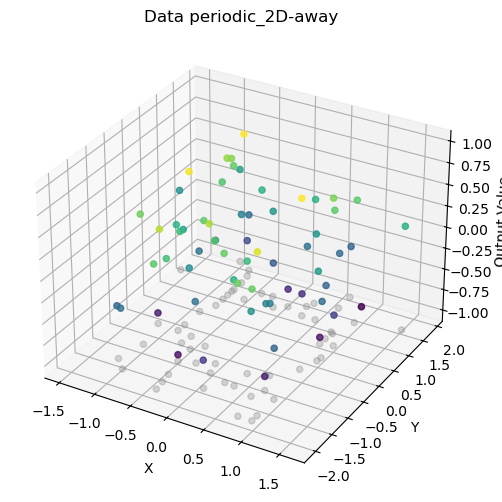

In [52]:


# Load the dataset
if pattern in datasets_2d:
    df = pandas.read_csv(datasets_2d[pattern].path, header=None)
    train_x = torch.tensor([df[0], df[1]], dtype=torch.float32)

# Generate the z axis
train_y = possible_datasets[dataset_name](train_x)

# Z score normalization
if data_normalization:
    train_x = (train_x - train_x.mean()) / train_x.std()
    if data_norm_y:
        train_y = (train_y - train_y.mean()) / train_y.std()

fig, ax = plot_3d_data(train_y, train_x[0], train_x[1], title_add=f"{dataset_name}-{pattern}", return_figure=True)
fig.savefig(f"{log_path}/data.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/data.pgf", bbox_inches='tight')

In [ ]:
len(train_x)

In [ ]:
## Define the GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
model_MAP = ExactGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)

In [ ]:
model

In [ ]:
param_names = [l[0] for l in list(model.named_parameters())]

In [ ]:
## Train the GPs
model.train()
likelihood.train()
mll_loss, model, likelihood, mll_train_log = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False, uninformed=uninformed)
mll_opt_params = [p.item() for p in model.parameters() if p.requires_grad]

In [ ]:
# Plot the optimization path of the trainings, each in an individual plot, given the parameter of interest
# The parameter progression is plotted as arrows pointing to the next parameter position
# The arrows are colored according to the lateness of their progression
# The colorbar shows the progression of the parameter


random_restarts = 2

f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]

xdim = 0
ydim = 1
# extract all the parameters

parameter_paths = [[log[0] for log in mll_train_log[i]] for i in range(len(mll_train_log))]
parameter_values = [[log[1] for log in mll_train_log[i]] for i in range(len(mll_train_log))]

for i, ax in enumerate(axs):
    # train log consists of a list of tuples, where the first element is the parameter vector and the second element is the loss
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model_MAP.train()
likelihood_MAP.train()
map_loss, model_MAP, likelihood_MAP, map_train_log = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True, uninformed=uninformed)
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

In [ ]:


f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]

# extract all the parameters
parameter_paths = [[log[0] for log in map_train_log[i]] for i in range(len(map_train_log))]
parameter_values = [[log[1] for log in map_train_log[i]] for i in range(len(map_train_log))]

xdim = 0
ydim = 1

for i, ax in enumerate(axs):
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax = axs[0]
ax_MAP = axs[1]
plot_model(model, likelihood, train_x, train_y, return_figure=False, figure=fig, ax=ax, loss_val=mll_loss.item(), loss_type="mll", display_figure=False)
plot_model(model_MAP, likelihood_MAP, train_x, train_y, return_figure=False, figure=fig, ax=ax_MAP, loss_val=map_loss.item(), loss_type="map")
fig.savefig(f"{log_path}/posterior.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/posterior.pgf", bbox_inches='tight')

In [ ]:
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

In [ ]:
unscaled_MLL = -mll_loss*len(*model.train_inputs)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

## Calculate the metrics
AIC_val, AIC_logs = AIC(unscaled_MLL, num_params)
BIC_val, BIC_logs = BIC(unscaled_MLL, num_params, torch.tensor(len(train_x)))
AIC_MAP_val, AIC_MAP_logs = AIC(unscaled_MAP, num_params)
BIC_MAP_val, BIC_MAP_logs = BIC(unscaled_MAP, num_params, torch.tensor(len(train_x)))
Lap0_val, Lap0_logs =     Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term=0)
LapAIC_val, LapAIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term=-1)
LapBIC_val, LapBIC_logs = Laplace(model_MAP, unscaled_MAP.clone(), uninformed=uninformed, param_punish_term="BIC")

In [ ]:
Lap0_logs

In [ ]:
LapAIC_logs

In [ ]:
LapBIC_logs

In [ ]:
model_evidences = list()
model_evidence_logs = list()
uninformed = True

In [ ]:
maxcall = 1e+1
if maxcall in levels:
    print(maxcall)
    Nested_val_e1, Nested_logs_e1 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e1)
    model_evidence_logs.append(Nested_logs_e1)

In [ ]:
maxcall = 1e+2
if maxcall in levels:
    print(maxcall)
    Nested_val_e2, Nested_logs_e2 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(Nested_val_e2)
    model_evidence_logs.append(Nested_logs_e2)

In [ ]:
maxcall = 1e+3
if maxcall in levels:
    print(maxcall)
    Nested_val_e3, Nested_logs_e3 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e3)
    model_evidence_logs.append(Nested_logs_e3)

In [ ]:
maxcall = 1e+4
if maxcall in levels:
    print(maxcall)
    Nested_val_e4, Nested_logs_e4 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e4)
    model_evidence_logs.append(Nested_logs_e4)

In [ ]:
maxcall = 1e+5
if maxcall in levels:
    print(maxcall)
    Nested_val_e5, Nested_logs_e5 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(Nested_val_e5)
    model_evidence_logs.append(Nested_logs_e5)

In [ ]:
for mod_log in model_evidence_logs:
    with open(f"{mod_log['res file']}", "rb") as f:
        res = dill.load(f)
    print(f"Num calls: {sum(res.ncall)}")
    print(f"logz Error: {res["logzerr"][-1]}")

In [ ]:

plot_mll_opt = True
std_filter = -1e-3
filter_type = "max" # ("mean"), "max", "none"
xdim = 0
ydim = 1

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, return_figure=False, title_add="", fig=f, ax=ax, display_figure=True, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "black"])
    else:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "black"])
    if ax == axs[0]:
        ax.set_ylabel(param_names[ydim])

In [ ]:
# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logl)
best_hyperparameters = res.samples[best_idx]

In [ ]:
# Optimal GP according to Nested sampling
fixed_reinit(model, torch.tensor(best_hyperparameters))
model.eval()
likelihood.eval()
# mll of best parameterization according to Nested sampling:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
nested_top_mll = (mll(model(train_x), train_y))*len(train_x)
nested_top_map = nested_top_mll+log_normalized_prior(model)*len(train_x)
fig, ax = plot_model(model, likelihood, train_x, train_y, return_figure=True, loss_val=res.logl[best_idx], loss_type="Nested logl")
ax.title.set_text(f"{ax.title.get_text()} ; MLL: {nested_top_mll.item():.2f}; MAP: {nested_top_map.item():.2f}\n MLL (u) {-nested_top_mll/len(train_x):.2f}; MAP (u) {-nested_top_map/len(train_x):.2f}")

In [ ]:
# Collect metric names and values into a list of tuples
metrics_data = [
    ("MLL", f"{unscaled_MLL.item():.3f}"),
    ("MLL (loss)", f"{mll_loss.item():.3f}"),
    ("AIC", f"{AIC_val.item():.3f}"),
    ("AIC (s)", f"{(AIC_val.item()*(-0.5)):.3f}"),
    ("BIC", f"{BIC_val.item():.3f}"),
    ("BIC (s)", f"{(BIC_val.item()*(-0.5)):.3f}"),
    

]
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [("MAP", f"{unscaled_MAP.item():.3f}"),
    ("MAP (loss)", f"{map_loss.item():.3f}"),
    ("AIC_M", f"{AIC_MAP_val.item():.3f}"),
    ("AIC_M (s)", f"{(AIC_MAP_val.item()*(-0.5)):.3f}"),
    ("BIC_M", f"{BIC_MAP_val.item():.3f}"),
    ("BIC_M (s)", f"{(BIC_MAP_val.item()*(-0.5)):.3f}"),
]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()


metrics_data=[    
    ("Lap", f"{Lap0_logs["laplace without replacement"].item():.3f}"),
    ("Lap0", f"{Lap0_val.item():.3f}"),
    ("LapAIC", f"{LapAIC_val.item():.3f}"),
    ("LapBIC", f"{LapBIC_val.item():.3f}"),
    ]


labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()
metrics_data = [    
    #("Nested (1)", f"{Nested_val_e1:.3f}"),
    #("Nested (3)", f"{Nested_val_e3:.3f}"),
    ("Nested (4)", f"{Nested_val_e4:.3f}"),
    ("Nested (5)", f"{Nested_val_e5:.3f}")
    ]
# Transpose the table: one row for the label, another for the value
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]

# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")

In [ ]:

fixed_reinit(model_MAP, torch.tensor(best_hyperparameters))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_MAP, model_MAP)
map_loss = -mll(model_MAP(train_x), train_y)-log_normalized_prior(model_MAP)
unscaled_MAP = -map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
Nested_Lap0_val, Nested_Lap0_logs = Laplace(model_MAP, unscaled_MAP, param_punish_term=0)
print(f"Lap0/nested = {Lap0_val/Nested_val_e5:.3f}")
print(f"AIC (s)/nested = {AIC_val*(-0.5)/Nested_val_e5:.3f}") 
print(f"nested Lap0/nested = {Nested_Lap0_val/Nested_val_e5:.3f}\n")
print("```python")
print(Nested_Lap0_val)

print(Nested_Lap0_logs)
print("```")

### Main loop

### Results visualization

In [ ]:
# The big figure with rows for each dataset and columns for [Dataset, Posterior (MLL), Posterior (MAP), Nested plot]


### XYZ